I want to try to figure out a way to do a Lagrangian approach in Python.
In Mathematica I'd define the Lagrangian and then do the Euler Lagrange equation:
$$\frac{\partial L}{\partial x_i}-\frac{d}{dt}\frac{\partial L}{\partial \dot{x}_i}=0$$
for all the variables $x_i$. In this notebook I'm going to try to basically do the same thing.

In [1]:
import sympy as sym
t=sym.Symbol('t')
theta = sym.Function('theta')(t)
phi = sym.Function('phi')(t)
L1,L2,m1,m2,g = sym.symbols('L1 L2 m1 m2 g') 
x1 = L1*sym.sin(theta)
x2 = x1 + L2*sym.sin(phi)
y1 = -L1*sym.cos(theta)
y2 = y1 - L2*sym.cos(phi)
V = m1*g*y1 + m2*g*y2 
T = (m1*(sym.diff(x1,t)**2+sym.diff(y1,t)**2)/2 + (m2*(sym.diff(x2,t)**2 + sym.diff(y2,t)**2)/2)) 
L = T-V
L

L1*g*m1*cos(theta(t)) - g*m2*(-L1*cos(theta(t)) - L2*cos(phi(t))) + m1*(L1**2*sin(theta(t))**2*Derivative(theta(t), t)**2 + L1**2*cos(theta(t))**2*Derivative(theta(t), t)**2)/2 + m2*((L1*sin(theta(t))*Derivative(theta(t), t) + L2*sin(phi(t))*Derivative(phi(t), t))**2 + (L1*cos(theta(t))*Derivative(theta(t), t) + L2*cos(phi(t))*Derivative(phi(t), t))**2)/2

That's pretty ugly, but sympy handles it fine. Next is to do the E-L stuff

In [2]:
theta_equation=sym.diff(L,theta)-sym.diff(L,theta.diff(t),t)
theta_equation

-L1*g*m1*sin(theta(t)) - L1*g*m2*sin(theta(t)) - L1*(L1*m1*(sin(theta(t))**2 + cos(theta(t))**2)*Derivative(theta(t), t, t) + m2*((L1*sin(theta(t))*Derivative(theta(t), t) + L2*sin(phi(t))*Derivative(phi(t), t))*cos(theta(t))*Derivative(theta(t), t) - (L1*cos(theta(t))*Derivative(theta(t), t) + L2*cos(phi(t))*Derivative(phi(t), t))*sin(theta(t))*Derivative(theta(t), t) - (L1*sin(theta(t))*Derivative(theta(t), t)**2 - L1*cos(theta(t))*Derivative(theta(t), t, t) + L2*sin(phi(t))*Derivative(phi(t), t)**2 - L2*cos(phi(t))*Derivative(phi(t), t, t))*cos(theta(t)) + (L1*sin(theta(t))*Derivative(theta(t), t, t) + L1*cos(theta(t))*Derivative(theta(t), t)**2 + L2*sin(phi(t))*Derivative(phi(t), t, t) + L2*cos(phi(t))*Derivative(phi(t), t)**2)*sin(theta(t)))) + m2*(2*L1*(L1*sin(theta(t))*Derivative(theta(t), t) + L2*sin(phi(t))*Derivative(phi(t), t))*cos(theta(t))*Derivative(theta(t), t) - 2*L1*(L1*cos(theta(t))*Derivative(theta(t), t) + L2*cos(phi(t))*Derivative(phi(t), t))*sin(theta(t))*Derivati

again pretty ugly, but it's all there. I'll do the same for phi:

In [3]:
phi_equation = sym.diff(L, phi) - sym.diff(L, phi.diff(t), t)
phi_equation

-L2*g*m2*sin(phi(t)) - L2*m2*((L1*sin(theta(t))*Derivative(theta(t), t) + L2*sin(phi(t))*Derivative(phi(t), t))*cos(phi(t))*Derivative(phi(t), t) - (L1*cos(theta(t))*Derivative(theta(t), t) + L2*cos(phi(t))*Derivative(phi(t), t))*sin(phi(t))*Derivative(phi(t), t) - (L1*sin(theta(t))*Derivative(theta(t), t)**2 - L1*cos(theta(t))*Derivative(theta(t), t, t) + L2*sin(phi(t))*Derivative(phi(t), t)**2 - L2*cos(phi(t))*Derivative(phi(t), t, t))*cos(phi(t)) + (L1*sin(theta(t))*Derivative(theta(t), t, t) + L1*cos(theta(t))*Derivative(theta(t), t)**2 + L2*sin(phi(t))*Derivative(phi(t), t, t) + L2*cos(phi(t))*Derivative(phi(t), t)**2)*sin(phi(t))) + m2*(2*L2*(L1*sin(theta(t))*Derivative(theta(t), t) + L2*sin(phi(t))*Derivative(phi(t), t))*cos(phi(t))*Derivative(phi(t), t) - 2*L2*(L1*cos(theta(t))*Derivative(theta(t), t) + L2*cos(phi(t))*Derivative(phi(t), t))*sin(phi(t))*Derivative(phi(t), t))/2

Ok, now we've got the equations we need. Unfortunately, in order to integrate them using odeint we need to turn most of the variables into dummy variables. I found this on a stackexchange site:

In [4]:
def dummify_undefined_functions(expr): 
    mapping = {} # replace all Derivative terms 
    for der in expr.atoms(sym.Derivative): 
        f_name = der.expr.func.__name__ 
        var_names = [var.name for var in der.variables] 
        name = "d%s_d%s" % (f_name, 'd'.join(var_names)) 
        mapping[der] = sym.Symbol(name) 
        # replace undefined functions 
        from sympy.core.function import AppliedUndef 
        for f in expr.atoms(AppliedUndef): 
            f_name = f.func.__name__ 
            mapping[f] = sym.Symbol(f_name) 
    return expr.subs(mapping)

That function can replace something like Derivative(theta(t), t, t) with dtheta_dtdt:

In [6]:
theta_equation_dummified=dummify_undefined_functions(theta_equation)
theta_equation_dummified

-L1*g*m1*sin(theta) - L1*g*m2*sin(theta) - L1*(L1*dtheta_dtdt*m1*(sin(theta)**2 + cos(theta)**2) + m2*(dtheta_dt*(L1*dtheta_dt*sin(theta) + L2*dphi_dt*sin(phi))*cos(theta) - dtheta_dt*(L1*dtheta_dt*cos(theta) + L2*dphi_dt*cos(phi))*sin(theta) - (L1*dtheta_dt**2*sin(theta) - L1*dtheta_dtdt*cos(theta) + L2*dphi_dt**2*sin(phi) - L2*dphi_dtdt*cos(phi))*cos(theta) + (L1*dtheta_dt**2*cos(theta) + L1*dtheta_dtdt*sin(theta) + L2*dphi_dt**2*cos(phi) + L2*dphi_dtdt*sin(phi))*sin(theta))) + m2*(2*L1*dtheta_dt*(L1*dtheta_dt*sin(theta) + L2*dphi_dt*sin(phi))*cos(theta) - 2*L1*dtheta_dt*(L1*dtheta_dt*cos(theta) + L2*dphi_dt*cos(phi))*sin(theta))/2

In [7]:
phi_equation_dummified=dummify_undefined_functions(phi_equation)

Ok, now we're getting somewhere. 

For odeint we'll need to solve those two equations for dtheta_dtdt and dphi_dtdt. What I found was you have to tell sympy that all the weirdo things from dummify_undefined_functions are symbols for the solve command to work

In [11]:
dphi_dt, dphi_dtdt, dtheta_dt, dtheta_dtdt = sym.symbols('dphi_dt, dphi_dtdt, dtheta_dt, dtheta_dtdt')
equations=sym.solve([theta_equation_dummified, phi_equation_dummified], [dtheta_dtdt, dphi_dtdt])
equations

{dtheta_dtdt: (L1*dtheta_dt**2*m2*sin(2*phi - 2*theta)/2 + L2*dphi_dt**2*m2*sin(phi - theta) - g*m1*sin(theta) - g*m2*sin(theta)/2 + g*m2*sin(2*phi - theta)/2)/(L1*(m1 - m2*cos(phi - theta)**2 + m2)),
 dphi_dtdt: (-(m1 + m2)*(L1*dtheta_dt**2*sin(phi - theta) + g*sin(phi)) + (-L2*dphi_dt**2*m2*sin(phi - theta) + g*m1*sin(theta) + g*m2*sin(theta))*cos(phi - theta))/(L2*(m1 - m2*cos(phi - theta)**2 + m2))}

Ok, now we're in business! Those two equations are ready to be used along with d(theta)/dt = dtheta_dt and d(phi)/dt = dphi_dt in odeint (along with setting all the other constants to values)

In [31]:
phi_subs = equations[dphi_dtdt].subs([(L1,1),(L2,1),(m1,1),(m2,1),(g,9.8)])
theta_subs = equations[dtheta_dtdt].subs([(L1,1),(L2,1),(m1,1),(m2,1),(g,9.8)])
phi_subs

(-2*dtheta_dt**2*sin(phi - theta) + (-dphi_dt**2*sin(phi - theta) + 19.6*sin(theta))*cos(phi - theta) - 19.6*sin(phi))/(-cos(phi - theta)**2 + 2)

In [32]:
phi, theta = sym.symbols('phi, theta')
phi_ode=sym.lambdify((phi, theta, dtheta_dt, dphi_dt), phi_subs, "sympy")
theta_ode = sym.lambdify((phi, theta, dtheta_dt, dphi_dt), theta_subs, "sympy")

In [45]:
from numpy import sqrt, linspace 
from scipy.integrate import odeint
from pylab import plot, axis, show

In [43]:
def odefunction(z, time):
    dphi_dt=z[3]
    dtheta_dt=z[2]
    theta = z[0]
    phi = z[1]
    return [dtheta_dt, dphi_dt, theta_ode(phi, theta, dtheta_dt, dphi_dt), phi_ode(phi, theta, dtheta_dt, dphi_dt)]

In [51]:
times=linspace(0,10,100)
res=odeint(odefunction,[np.pi/2, np.pi/2,0,0],times)

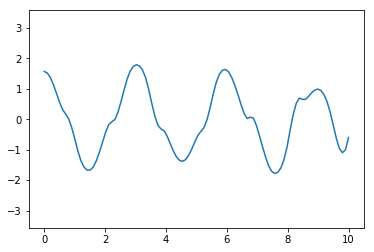

In [52]:
plot(times, res[:,0]) 
axis('equal') 
show()

In [40]:
theta_ode

<function <lambda>>